# Lab 10 AutoEncoder 



In [1]:
import torchvision
from math import floor, ceil
import torch
from torch import nn
import tqdm
import numpy as np
torch.cuda.empty_cache()
batch_size_train = 64 #Define train batch size
batch_size_test  = 256 #Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size_test,
                                          shuffle=True)

print(len(train_loader))
print(len(test_loader))

938
40


In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('gpu')
print(device)

cuda:0


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=64, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [17]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2,stride=2),
            Flatten(),
            nn.Linear(7*7*64,5*5*64),
            nn.Tanh(),
            nn.Linear(5*5*64,3*3*64)
        )
        self.decoder =nn.Sequential(
            nn.Linear(3*3*64,5*5*64),
            nn.Tanh(),
            nn.Linear(5*5*64,7*7*64),
            Unflatten(),
            nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1),
        )
    
    def forward(self,x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out,latent


In [18]:
loss_fn = nn.MSELoss().to(device)
model = AE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay =1e-6)

epochs =10

loss_list =[]
val_loss_list=[]
iteration_list=[]
accuracy_list=[]
log_interval = 200

count=0

for epoch in tqdm.trange(epochs):
  print( '='*40)
  model.train()
  for idx, (data,label) in enumerate(train_loader):
    pred,latent = model(data.to(device))
    loss = loss_fn(pred, data.to(device))

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if idx %log_interval ==0:
      print('Train epoch {} [{}/{} {:.0f}%], loss : {:.4f}'.format(epoch, idx*batch_size_train,
            len(train_loader)*batch_size_train, 100*idx/len(train_loader),loss.item()))
      loss_list.append(loss.item())
      count+=log_interval
      iteration_list.append(count)
  model.eval()
  with torch.no_grad():  
    val_loss =0
    test_num=0
    for data, label in test_loader:
      pred,latent=model(data.to(device))
      val_loss+=loss_fn(pred,data.to(device)).item()
      test_num +=len(label)
    val_loss=val_loss/test_num
    val_loss_list.append(val_loss)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Train epoch 0 [0/60032 0%], loss : 5.4810
Train epoch 0 [12800/60032 21%], loss : 0.2777
Train epoch 0 [25600/60032 43%], loss : 0.1791
Train epoch 0 [38400/60032 64%], loss : 0.1448
Train epoch 0 [51200/60032 85%], loss : 0.1148


 10%|████████▍                                                                           | 1/10 [01:00<09:02, 60.29s/it]

Train epoch 1 [0/60032 0%], loss : 0.1047
Train epoch 1 [12800/60032 21%], loss : 0.1074
Train epoch 1 [25600/60032 43%], loss : 0.0960
Train epoch 1 [38400/60032 64%], loss : 0.0782
Train epoch 1 [51200/60032 85%], loss : 0.0873


 20%|████████████████▊                                                                   | 2/10 [01:30<05:42, 42.85s/it]

Train epoch 2 [0/60032 0%], loss : 0.0792
Train epoch 2 [12800/60032 21%], loss : 0.0714
Train epoch 2 [25600/60032 43%], loss : 0.0682
Train epoch 2 [38400/60032 64%], loss : 0.0694
Train epoch 2 [51200/60032 85%], loss : 0.0647


 30%|█████████████████████████▏                                                          | 3/10 [02:02<04:24, 37.81s/it]

Train epoch 3 [0/60032 0%], loss : 0.0601
Train epoch 3 [12800/60032 21%], loss : 0.0605
Train epoch 3 [25600/60032 43%], loss : 0.0642
Train epoch 3 [38400/60032 64%], loss : 0.0547
Train epoch 3 [51200/60032 85%], loss : 0.0519


 40%|█████████████████████████████████▌                                                  | 4/10 [02:57<04:28, 44.69s/it]

Train epoch 4 [0/60032 0%], loss : 0.0532
Train epoch 4 [12800/60032 21%], loss : 0.0501
Train epoch 4 [25600/60032 43%], loss : 0.0524
Train epoch 4 [38400/60032 64%], loss : 0.0474
Train epoch 4 [51200/60032 85%], loss : 0.0460


 50%|██████████████████████████████████████████                                          | 5/10 [04:08<04:29, 53.95s/it]

Train epoch 5 [0/60032 0%], loss : 0.0465
Train epoch 5 [12800/60032 21%], loss : 0.0446
Train epoch 5 [25600/60032 43%], loss : 0.0417
Train epoch 5 [38400/60032 64%], loss : 0.0405
Train epoch 5 [51200/60032 85%], loss : 0.0428


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [04:38<03:03, 45.93s/it]

Train epoch 6 [0/60032 0%], loss : 0.0387
Train epoch 6 [12800/60032 21%], loss : 0.0382
Train epoch 6 [25600/60032 43%], loss : 0.0374
Train epoch 6 [38400/60032 64%], loss : 0.0400
Train epoch 6 [51200/60032 85%], loss : 0.0385


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [05:11<02:05, 41.67s/it]

Train epoch 7 [0/60032 0%], loss : 0.0386
Train epoch 7 [12800/60032 21%], loss : 0.0346
Train epoch 7 [25600/60032 43%], loss : 0.0350
Train epoch 7 [38400/60032 64%], loss : 0.0348
Train epoch 7 [51200/60032 85%], loss : 0.0329


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [06:08<01:32, 46.48s/it]

Train epoch 8 [0/60032 0%], loss : 0.0315
Train epoch 8 [12800/60032 21%], loss : 0.0333
Train epoch 8 [25600/60032 43%], loss : 0.0319
Train epoch 8 [38400/60032 64%], loss : 0.0311
Train epoch 8 [51200/60032 85%], loss : 0.0293


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [06:41<00:42, 42.32s/it]

Train epoch 9 [0/60032 0%], loss : 0.0325
Train epoch 9 [12800/60032 21%], loss : 0.0324
Train epoch 9 [25600/60032 43%], loss : 0.0293
Train epoch 9 [38400/60032 64%], loss : 0.0312
Train epoch 9 [51200/60032 85%], loss : 0.0295


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [07:23<00:00, 44.38s/it]


In [20]:
data = data.cpu().detach().numpy()
pred = pred.cpu().detach().numpy()
data = data.squeeze()
pred =pred.squeeze()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

# Visualization 

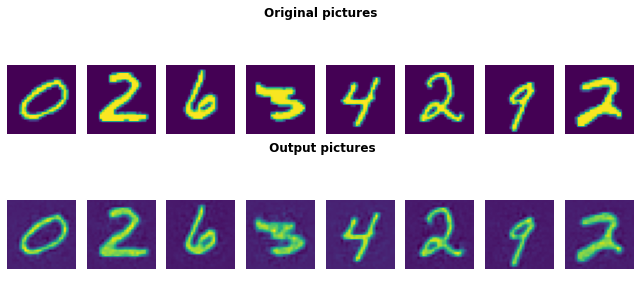

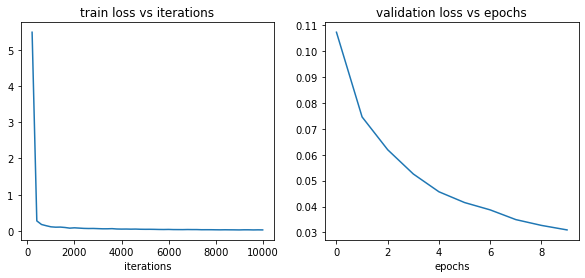

In [21]:
from matplotlib.gridspec import SubplotSpec
import matplotlib.pyplot as plt

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

def  visualize(num_pairs=5):

  fig, ax = plt.subplots(2,num_pairs,figsize=(9,4))
  grid =plt.GridSpec(2,num_pairs)
  create_subtitle(fig,grid[0,::],'Original pictures')
  create_subtitle(fig,grid[1,::], '\n Output pictures')
  for i in range(num_pairs):
    ax[0][i].imshow(data[i,:,:])
    ax[1][i].imshow(pred[i,:,:])
    ax[0][i].axis('off')
    ax[1][i].axis('off')

  fig.tight_layout()
  fig.set_facecolor('w')
  fig,ax = plt.subplots(1,2,figsize=(10,4))
  ax[0].plot(iteration_list,loss_list)
  ax[1].plot(val_loss_list)
  ax[0].set_title('train loss vs iterations')
  ax[0].set_xlabel('iterations')
  ax[1].set_title('validation loss vs epochs')
  ax[1].set_xlabel('epochs')
  
visualize(8)

## PCA on code vector in latent space

In [ ]:
model = model.to('cpu')

latent_testloader = torch.utils.data.DataLoader(test_set,batch_size=10000,shuffle=False)
for data, label in latent_testloader:
    pred, latent = model(data)
    
U, S, VT = torch.pca_lowrank(latent)    

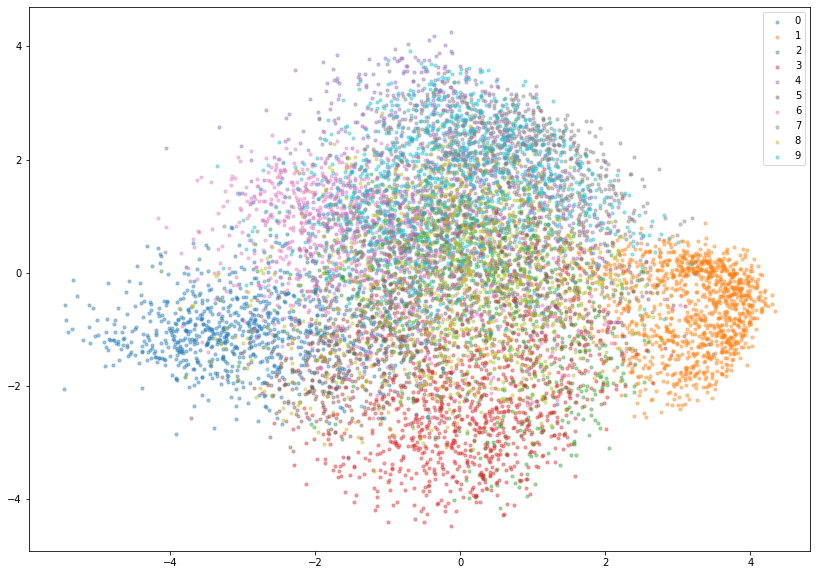

In [32]:
plt.figure(figsize = (14,10))

for i in range(10):
  mask = label == i
  Y = (U[mask]@torch.diag(S)).detach()
  plt.scatter(Y[:,0], Y[:,1], label = i, alpha = 0.4, s = 10)
  plt.legend()

## Direct PCA on input

In [ ]:
data = data.view(data.shape[0],-1).numpy()
U, S, VT = torch.pca_lowrank(latent)    

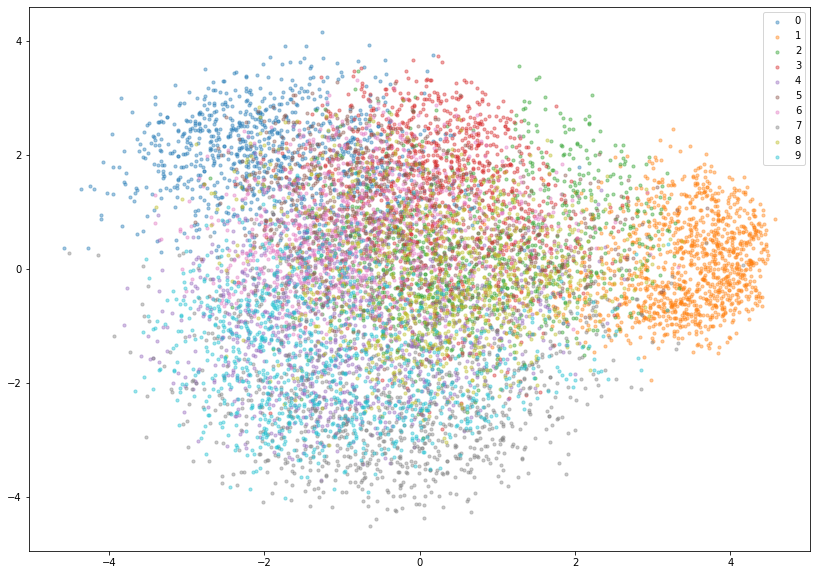

In [37]:
plt.figure(figsize = (14,10))

for i in range(10):
  mask = label == i
  Y = (U[mask]@torch.diag(S)).detach()
  plt.scatter(Y[:,0], Y[:,1], label = i, alpha = 0.4, s = 10)
  plt.legend()

# Vaiational Auto-Encoder


In [75]:
import torchvision
from math import floor, ceil
import torch
from torch import nn
import tqdm
import numpy as np
torch.cuda.empty_cache()
batch_size_train = 64 #Define train batch size
batch_size_test  = 256 #Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size_test,
                                          shuffle=True)

print(len(train_loader))
print(len(test_loader))

938
40


In [76]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('gpu')
print(device)

cuda:0


In [77]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=64, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [112]:
class AE(nn.Module):
    def __init__(self, p_drop = 0.2):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,stride=1,padding=2),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.01),
                nn.MaxPool2d(kernel_size=2,stride=2),
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.01),
                nn.MaxPool2d(kernel_size=2,stride=2),
                Flatten(),
        )
        self.mus = nn.Sequential(
                nn.Linear(7*7*64,4*4*64),
                nn.Tanh(),
                nn.Linear(4*4*64,1*1*64),
                nn.Dropout( p =p_drop)
            )
        self.vars = nn.Sequential(
                nn.Linear(7*7*64,4*4*64),
                nn.Tanh(),
                nn.Linear(4*4*64,1*1*64),
                nn.Dropout( p =p_drop)
            ) 
        
        self.decoder =nn.Sequential(
                nn.Linear(1*1*64,4*4*64),
                nn.Tanh(),
                nn.Linear(4*4*64,7*7*64),
                Unflatten(),
                nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(64),
                nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1),
            )  
    
    def forward(self, x):
        h = self.encoder(x)
        mus = self.mus(h)
        var = self.vars(h)
        sample = self.reparameterize(mus,var)
        
        return self.decoder(sample),sample,(mus,var)

    def reparameterize(self, mu, logvar):
        '''
        Used to generate sample from latent Gaussian
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    #self.drop = nn.Dropout(p = p_drop)
#
    ##Define Encoder Layers
    #self.fc_e1 = nn.Linear(in_features = input_size, out_features = input_size//8)
    #self.fc_e2_1 = nn.Linear(in_features = input_size//8, out_features = latent_size)
    #self.fc_e2_2 = nn.Linear(in_features = input_size//8, out_features = latent_size)
#
    ##Define Decoder Layers
    #self.fc_d1 = nn.Linear(in_features = latent_size, out_features = input_size//4)
    #self.fc_d2 = nn.Linear(in_features = input_size//4, out_features = input_size)
    #self.act = nn.ReLU()
    #
  #def decoder(self,z):
  #  dec = self.drop(nn.Tanh()(self.fc_d1(z)))
  #  output = self.fc_d2(dec)
  #  return self.act(output)

  #def forward(self, input):
  #  
  #  enc = self.drop(nn.Tanh()(self.fc_e1(input.view(-1,28*28))))
  #  mus = self.fc_e2_1(enc) #means of latent Gaussian
  #  var =self.fc_e2_2(enc)  #(log) var of latent Gaussian
  #  sample = self.reparameterize(mus, var)
#
  #  
  #  return self.decoder(sample), sample, (mus, var)



In [113]:
# If implementing VAE:
def kld_loss(mus, vars):
  # Define KLD loss with standard normal prior
    loss = -0.5*torch.sum(vars-vars.exp()-mus.pow(2)+1)
    return loss.sum()/(mus.shape[0]*mus.shape[1])
                       

In [114]:
loss_fn = nn.MSELoss().to(device)
model = AE(p_drop=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay =1e-6)

epochs =40

loss_list =[]
val_loss_list=[]
iteration_list=[]
accuracy_list=[]
log_interval = 400
count=0
for epoch in tqdm.trange(epochs):
  print( '='*40)
  model.train()
  for idx, (data,label) in enumerate(train_loader):
    pred,latent,(mus,var) = model(data.to(device))
    #print(mus.shape)
    #print(var.shape)
    #print(torch.trace(var).shape)
    #print((mus.T@mus).shape)
    #print(torch.det(var).shape)
    
    loss = loss_fn(pred, data.to(device))+0.01*kld_loss(mus,var)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if idx %log_interval ==0:
      print('Train epoch {} [{}/{} {:.0f}%], loss : {:.4f}'.format(epoch, idx*batch_size_train,
            len(train_loader)*batch_size_train, 100*idx/len(train_loader),loss.item()))
      loss_list.append(loss.item())
      count+=log_interval
      iteration_list.append(count)
  model.eval()
  with torch.no_grad():  
    val_loss =0
    test_num=0
    for data, label in test_loader:
      pred,latent,(mus,var)=model(data.to(device))
      val_loss+=loss_fn(pred,data.to(device))+0.01*kld_loss(mus,var)
      test_num +=len(label)
    val_loss=val_loss/test_num
    val_loss_list.append(val_loss.item())

  0%|                                                                                            | 0/40 [00:00<?, ?it/s]

Train epoch 0 [0/60032 0%], loss : 5.8417
Train epoch 0 [25600/60032 43%], loss : 0.7875
Train epoch 0 [51200/60032 85%], loss : 0.6315


  2%|██                                                                                  | 1/40 [01:05<42:23, 65.21s/it]

Train epoch 1 [0/60032 0%], loss : 0.5671
Train epoch 1 [25600/60032 43%], loss : 0.4863
Train epoch 1 [51200/60032 85%], loss : 0.4620


  5%|████▏                                                                               | 2/40 [01:35<28:11, 44.52s/it]

Train epoch 2 [0/60032 0%], loss : 0.4362
Train epoch 2 [25600/60032 43%], loss : 0.3874
Train epoch 2 [51200/60032 85%], loss : 0.3833


  8%|██████▎                                                                             | 3/40 [02:05<23:25, 37.99s/it]

Train epoch 3 [0/60032 0%], loss : 0.3835
Train epoch 3 [25600/60032 43%], loss : 0.3310
Train epoch 3 [51200/60032 85%], loss : 0.3049


 10%|████████▍                                                                           | 4/40 [02:47<23:51, 39.75s/it]

Train epoch 4 [0/60032 0%], loss : 0.3389
Train epoch 4 [25600/60032 43%], loss : 0.3236
Train epoch 4 [51200/60032 85%], loss : 0.2990


 12%|██████████▌                                                                         | 5/40 [03:35<24:55, 42.74s/it]

Train epoch 5 [0/60032 0%], loss : 0.3090
Train epoch 5 [25600/60032 43%], loss : 0.2834
Train epoch 5 [51200/60032 85%], loss : 0.2759


 15%|████████████▌                                                                       | 6/40 [04:20<24:38, 43.48s/it]

Train epoch 6 [0/60032 0%], loss : 0.2732
Train epoch 6 [25600/60032 43%], loss : 0.2904
Train epoch 6 [51200/60032 85%], loss : 0.2738


 18%|██████████████▋                                                                     | 7/40 [05:09<24:49, 45.14s/it]

Train epoch 7 [0/60032 0%], loss : 0.2694
Train epoch 7 [25600/60032 43%], loss : 0.2663
Train epoch 7 [51200/60032 85%], loss : 0.2383


 20%|████████████████▊                                                                   | 8/40 [05:51<23:32, 44.15s/it]

Train epoch 8 [0/60032 0%], loss : 0.2605
Train epoch 8 [25600/60032 43%], loss : 0.2596
Train epoch 8 [51200/60032 85%], loss : 0.2558


 22%|██████████████████▉                                                                 | 9/40 [06:42<23:51, 46.18s/it]

Train epoch 9 [0/60032 0%], loss : 0.2461
Train epoch 9 [25600/60032 43%], loss : 0.2482
Train epoch 9 [51200/60032 85%], loss : 0.2268


 25%|████████████████████▊                                                              | 10/40 [07:22<22:07, 44.26s/it]

Train epoch 10 [0/60032 0%], loss : 0.2454
Train epoch 10 [25600/60032 43%], loss : 0.2451
Train epoch 10 [51200/60032 85%], loss : 0.2243


 28%|██████████████████████▊                                                            | 11/40 [08:06<21:26, 44.37s/it]

Train epoch 11 [0/60032 0%], loss : 0.2333
Train epoch 11 [25600/60032 43%], loss : 0.2183
Train epoch 11 [51200/60032 85%], loss : 0.2224


 30%|████████████████████████▉                                                          | 12/40 [08:50<20:39, 44.28s/it]

Train epoch 12 [0/60032 0%], loss : 0.2211
Train epoch 12 [25600/60032 43%], loss : 0.2351
Train epoch 12 [51200/60032 85%], loss : 0.2323


 32%|██████████████████████████▉                                                        | 13/40 [09:19<17:51, 39.70s/it]

Train epoch 13 [0/60032 0%], loss : 0.2101
Train epoch 13 [25600/60032 43%], loss : 0.2205
Train epoch 13 [51200/60032 85%], loss : 0.2170


 35%|█████████████████████████████                                                      | 14/40 [09:50<16:03, 37.06s/it]

Train epoch 14 [0/60032 0%], loss : 0.2223
Train epoch 14 [25600/60032 43%], loss : 0.2265
Train epoch 14 [51200/60032 85%], loss : 0.2180


 38%|███████████████████████████████▏                                                   | 15/40 [10:29<15:38, 37.56s/it]

Train epoch 15 [0/60032 0%], loss : 0.2251
Train epoch 15 [25600/60032 43%], loss : 0.2096
Train epoch 15 [51200/60032 85%], loss : 0.2291


 40%|█████████████████████████████████▏                                                 | 16/40 [11:06<14:56, 37.34s/it]

Train epoch 16 [0/60032 0%], loss : 0.2106
Train epoch 16 [25600/60032 43%], loss : 0.2177
Train epoch 16 [51200/60032 85%], loss : 0.1991


 42%|███████████████████████████████████▎                                               | 17/40 [11:40<13:56, 36.36s/it]

Train epoch 17 [0/60032 0%], loss : 0.2119
Train epoch 17 [25600/60032 43%], loss : 0.2197
Train epoch 17 [51200/60032 85%], loss : 0.1878


 45%|█████████████████████████████████████▎                                             | 18/40 [12:31<14:54, 40.68s/it]

Train epoch 18 [0/60032 0%], loss : 0.2123
Train epoch 18 [25600/60032 43%], loss : 0.1999
Train epoch 18 [51200/60032 85%], loss : 0.2337


 48%|███████████████████████████████████████▍                                           | 19/40 [13:01<13:05, 37.42s/it]

Train epoch 19 [0/60032 0%], loss : 0.2050
Train epoch 19 [25600/60032 43%], loss : 0.2134
Train epoch 19 [51200/60032 85%], loss : 0.2047


 50%|█████████████████████████████████████████▌                                         | 20/40 [13:30<11:40, 35.03s/it]

Train epoch 20 [0/60032 0%], loss : 0.1962
Train epoch 20 [25600/60032 43%], loss : 0.2001
Train epoch 20 [51200/60032 85%], loss : 0.1984


 52%|███████████████████████████████████████████▌                                       | 21/40 [14:06<11:08, 35.21s/it]

Train epoch 21 [0/60032 0%], loss : 0.1929
Train epoch 21 [25600/60032 43%], loss : 0.2181
Train epoch 21 [51200/60032 85%], loss : 0.1927


 55%|█████████████████████████████████████████████▋                                     | 22/40 [14:36<10:09, 33.88s/it]

Train epoch 22 [0/60032 0%], loss : 0.1850
Train epoch 22 [25600/60032 43%], loss : 0.1993
Train epoch 22 [51200/60032 85%], loss : 0.1902


 57%|███████████████████████████████████████████████▋                                   | 23/40 [15:07<09:17, 32.80s/it]

Train epoch 23 [0/60032 0%], loss : 0.1996
Train epoch 23 [25600/60032 43%], loss : 0.1852
Train epoch 23 [51200/60032 85%], loss : 0.1816


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [16:01<10:27, 39.23s/it]

Train epoch 24 [0/60032 0%], loss : 0.1976
Train epoch 24 [25600/60032 43%], loss : 0.1899
Train epoch 24 [51200/60032 85%], loss : 0.1967


 62%|███████████████████████████████████████████████████▉                               | 25/40 [16:32<09:11, 36.75s/it]

Train epoch 25 [0/60032 0%], loss : 0.2079
Train epoch 25 [25600/60032 43%], loss : 0.1983
Train epoch 25 [51200/60032 85%], loss : 0.1831


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [17:04<08:16, 35.45s/it]

Train epoch 26 [0/60032 0%], loss : 0.2055
Train epoch 26 [25600/60032 43%], loss : 0.1802
Train epoch 26 [51200/60032 85%], loss : 0.1732


 68%|████████████████████████████████████████████████████████                           | 27/40 [17:38<07:35, 35.00s/it]

Train epoch 27 [0/60032 0%], loss : 0.1800
Train epoch 27 [25600/60032 43%], loss : 0.1789
Train epoch 27 [51200/60032 85%], loss : 0.1936


 70%|██████████████████████████████████████████████████████████                         | 28/40 [18:12<06:56, 34.70s/it]

Train epoch 28 [0/60032 0%], loss : 0.2093
Train epoch 28 [25600/60032 43%], loss : 0.1757
Train epoch 28 [51200/60032 85%], loss : 0.1984


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [18:44<06:11, 33.80s/it]

Train epoch 29 [0/60032 0%], loss : 0.1816
Train epoch 29 [25600/60032 43%], loss : 0.1902
Train epoch 29 [51200/60032 85%], loss : 0.1776


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [19:15<05:29, 32.94s/it]

Train epoch 30 [0/60032 0%], loss : 0.1815
Train epoch 30 [25600/60032 43%], loss : 0.1823
Train epoch 30 [51200/60032 85%], loss : 0.1875


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [19:57<05:22, 35.80s/it]

Train epoch 31 [0/60032 0%], loss : 0.1945
Train epoch 31 [25600/60032 43%], loss : 0.1790
Train epoch 31 [51200/60032 85%], loss : 0.1838


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [20:28<04:34, 34.35s/it]

Train epoch 32 [0/60032 0%], loss : 0.1911
Train epoch 32 [25600/60032 43%], loss : 0.1873
Train epoch 32 [51200/60032 85%], loss : 0.1976


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [21:00<03:55, 33.61s/it]

Train epoch 33 [0/60032 0%], loss : 0.1974
Train epoch 33 [25600/60032 43%], loss : 0.1847
Train epoch 33 [51200/60032 85%], loss : 0.1810


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [21:53<03:56, 39.46s/it]

Train epoch 34 [0/60032 0%], loss : 0.1798
Train epoch 34 [25600/60032 43%], loss : 0.1806
Train epoch 34 [51200/60032 85%], loss : 0.1784


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [22:25<03:05, 37.09s/it]

Train epoch 35 [0/60032 0%], loss : 0.1863
Train epoch 35 [25600/60032 43%], loss : 0.1882
Train epoch 35 [51200/60032 85%], loss : 0.1842


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [23:07<02:34, 38.52s/it]

Train epoch 36 [0/60032 0%], loss : 0.1854
Train epoch 36 [25600/60032 43%], loss : 0.1814
Train epoch 36 [51200/60032 85%], loss : 0.1859


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [23:51<02:00, 40.09s/it]

Train epoch 37 [0/60032 0%], loss : 0.1768
Train epoch 37 [25600/60032 43%], loss : 0.1735
Train epoch 37 [51200/60032 85%], loss : 0.1743


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [24:42<01:27, 43.53s/it]

Train epoch 38 [0/60032 0%], loss : 0.1845
Train epoch 38 [25600/60032 43%], loss : 0.1970
Train epoch 38 [51200/60032 85%], loss : 0.1651


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [25:34<00:46, 46.16s/it]

Train epoch 39 [0/60032 0%], loss : 0.1858
Train epoch 39 [25600/60032 43%], loss : 0.1754
Train epoch 39 [51200/60032 85%], loss : 0.1653


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [26:13<00:00, 39.34s/it]


In [95]:
data = data.cpu().detach().numpy()
pred = pred.cpu().detach().view(-1,28,28).numpy()
data = data.squeeze()
pred =pred.squeeze()

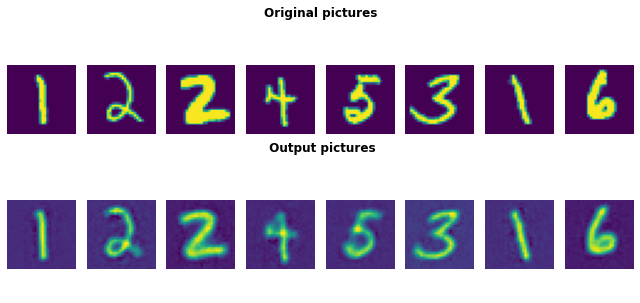

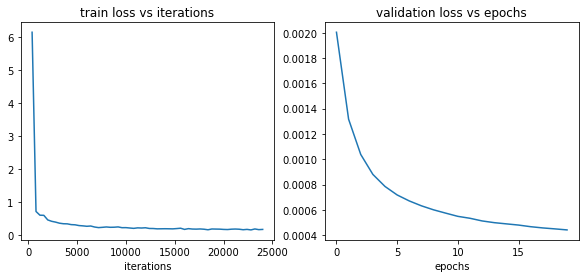

In [96]:
from matplotlib.gridspec import SubplotSpec
import matplotlib.pyplot as plt

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

def  visualize(num_pairs=5):

  fig, ax = plt.subplots(2,num_pairs,figsize=(9,4))
  grid =plt.GridSpec(2,num_pairs)
  create_subtitle(fig,grid[0,::],'Original pictures')
  create_subtitle(fig,grid[1,::], '\n Output pictures')
  for i in range(num_pairs):
    ax[0][i].imshow(data[i,:,:])
    ax[1][i].imshow(pred[i,:].reshape(28,28))
    ax[0][i].axis('off')
    ax[1][i].axis('off')

  fig.tight_layout()
  fig.set_facecolor('w')
  fig,ax = plt.subplots(1,2,figsize=(10,4))
  ax[0].plot(iteration_list,loss_list)
  ax[1].plot(val_loss_list)
  ax[0].set_title('train loss vs iterations')
  ax[0].set_xlabel('iterations')
  ax[1].set_title('validation loss vs epochs')
  ax[1].set_xlabel('epochs')
  
visualize(8)

In [67]:
model = model.to('cpu')
latent_testloader = torch.utils.data.DataLoader(test_set,batch_size=10000,shuffle=False)
for data, label in latent_testloader:
    pred, latent,(mus,var) = model(data)
U, S, VT = torch.pca_lowrank(latent)    

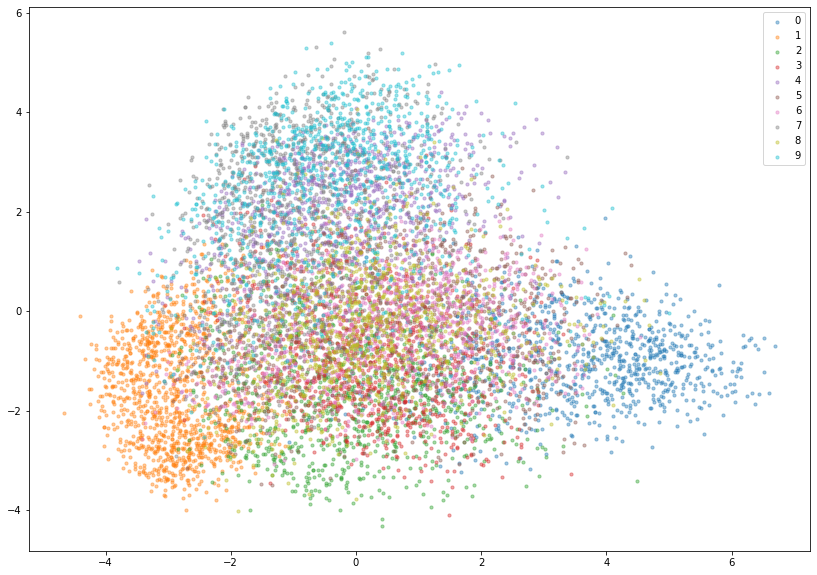

In [30]:
plt.figure(figsize = (14,10))

for i in range(10):
  mask = label == i
  Y = (U[mask]@torch.diag(S)).detach()
  plt.scatter(Y[:,0], Y[:,1], label = i, alpha = 0.4, s = 10)
  plt.legend()

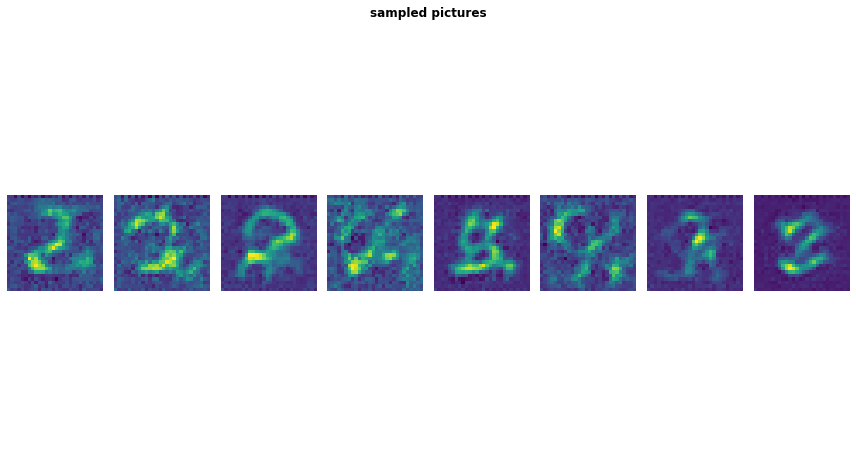

In [111]:
with torch.no_grad():
    z = torch.randn(64, 64).to(device)
    sample = model.decoder(z).to(device)

sample = sample.cpu().detach().view(-1,28,28).numpy()
sample = sample.squeeze()

from matplotlib.gridspec import SubplotSpec
import matplotlib.pyplot as plt

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

def  visualize(num_pairs=5):

  fig, ax = plt.subplots(1,num_pairs,figsize=(12,6))
  grid =plt.GridSpec(1,num_pairs)
  create_subtitle(fig,grid[0,::],'sampled pictures')
  for i in range(num_pairs):
    ax[i].imshow(sample[i,:].reshape(28,28))
    ax[i].axis('off')

  fig.tight_layout()
  fig.set_facecolor('w')

visualize(8)